In [1]:
import settings
import logging
import os
from time import time
log_file = os.path.join(settings.project_root, 'tmp', 'Model_Optimizations.log')
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logger = logging.getLogger('text_similar')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',  level=logging.DEBUG, filename=log_file)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

In [3]:
STOPWORDS = """
a about above across after afterwards again against all almost alone along already also although always am among amongst amoungst amount an and another any anyhow anyone anything anyway anywhere are around as at back be
became because become becomes becoming been before beforehand behind being below beside besides between beyond bill both bottom but by call can
cannot cant co computer con could couldnt cry de describe
detail did didn do does doesn doing don done down due during
each eg eight either eleven else elsewhere empty enough etc even ever every everyone everything everywhere except few fifteen
fify fill find fire first five for former formerly forty found four from front full further get give go
had hand has hasnt have he head hence her here hereafter hereby herein hereupon hers herself him himself his how however hundred i ie
if in inc indeed interest into is it its itself keep last latter latterly least less ltd
just
kg km
made make many may me meanwhile might mill mine more moreover most mostly move much must my myself name namely
neither never nevertheless next nine no nobody none noone nor not nothing now nowhere of off
often on once one only onto or other others otherwise our ours ourselves out over own part per
perhaps please put rather re
quite
rather really regarding
same say said see seem seemed seeming seems serious several she should show side since sincere six sixty so some somehow someone something sometime sometimes somewhere still such system take ten
than that the their them themselves then thence there thereafter thereby therefore therein thereupon these they thick thin third this those though three through throughout thru thus to together too top toward towards twelve twenty two un under
until up unless upon us used using
various very very via
was we well were what whatever when whence whenever where whereafter whereas whereby wherein whereupon wherever whether which while whither who whoever whole whom whose why will with within without would yet you
your yours yourself yourselves
"""
STOPWORDS = {word for word in STOPWORDS.split()}
lemmat = WordNetLemmatizer()
def lemmatizer(story):
    return ' '.join([lemmat.lemmatize(word.lower()) for word in story.split() if len(word)>3 and word not in STOPWORDS])

In [4]:
def load_data(f_name):
    if os.path.isfile(f_name+'.pickle'):
        df = pd.read_pickle(f_name+'.pickle')
    else:
        logger.info('Loading data into dataFrame')
        df = pd.DataFrame([line.split(',') for line in open(f_name+'.csv')], columns=['genre', 'story'])
        df['charlen'] = [len(story) for story in df['story']]
        df = df[df['charlen']>2000]
        df['story'] = df['story'].map(lemmatizer)
        final_data_pickle = os.path.join(settings.project_root, 'tmp', 'final_data.pickle')
        df.to_pickle(final_data_pickle)
    return df

In [5]:
df = load_data(os.path.join(settings.project_root, 'tmp', 'data_file'))
df = df.sample(frac=1).reset_index(drop=True)
genres = df['genre'].unique()

In [6]:
test_size = 0.10
logger.info('Creating Train-text split with test_size = {}'.format(test_size))
train_data, test_data = train_test_split(df, test_size=test_size, random_state=42)

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    target_names = genres
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    print('f1_Score : {}'.format(f1_score(target, predictions), labels=genres, pos_label=None, average='weighted'))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    print('classification report')
    print(classification_report(predictions, target, target_names=genres))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    logger.info('plotting confusion matrix')
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [8]:
def dummy_predictor(samples):
    return np.random.choice(genres, len(samples))
baseline_predictions = dummy_predictor(test_data['story'])

accuracy 0.202036021926
f1_Score : 0.201990151925
confusion matrix
 [[387 345 335 347 339]
 [370 341 316 335 395]
 [368 352 346 340 349]
 [374 371 352 370 394]
 [355 370 360 366 362]]
(row=expected, col=predicted)
classification report
              precision    recall  f1-score   support

      Sci-Fi       0.22      0.21      0.21      1854
       Humor       0.19      0.19      0.19      1779
Supernatural       0.20      0.20      0.20      1709
      Family       0.20      0.21      0.20      1758
     Romance       0.20      0.20      0.20      1839

 avg / total       0.20      0.20      0.20      8939



C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


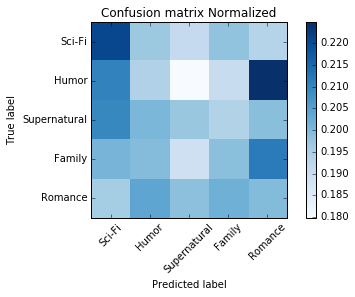

In [9]:
evaluate_prediction(baseline_predictions, test_data['genre'])

In [10]:
bow_params = {'analyzer': 'word',
              'tokenizer': word_tokenize,
              'max_df': 0.5,
              'max_features': 50000,
              'min_df': 10
             }

classifier_params = {'n_estimators': 100,
                     'criterion': 'gini',
                     'min_samples_split': 5,
                     'bootstrap': False,
                     'n_jobs': -1, 
                     'random_state':42
                    }

# tfidf_params = bow_params.copy()
tfidf_params = {'norm': 'l1', 'use_idf': True}



bow_vectorizer = CountVectorizer(**bow_params)
tfidf_vectorizer = TfidfTransformer(**tfidf_params)
classifier = RandomForestClassifier(**classifier_params)

In [11]:
bow_train = bow_vectorizer.fit_transform(train_data['story'])
bow_test = bow_vectorizer.transform(test_data['story'])

In [12]:
bow_nmf_params = {'NMF__n_components': [5, 25, 100, 150],
                  'NMF__tol': [0.0001, 0.001, 0.005], 
                  'NMF__max_iter': [100, 300, 500]
                  }

In [13]:
bow_nmf = Pipeline([('NMF', NMF(init='nndsvd', solver='cd', random_state=42)),
                    ('classifier', classifier)
                    ])

In [14]:
bow_nmf_grid_search = RandomizedSearchCV(estimator=bow_nmf,
                                         param_distributions=bow_nmf_params,
                                         n_iter=10,
                                         scoring='f1_weighted',
                                         n_jobs=-1,
                                         verbose=1,
                                         random_state=42
                                         )

In [15]:
bow_nmf_grid_search.fit(bow_train, train_data['genre'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 219.1min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('NMF', NMF(alpha=0.0, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.0, max_iter=200,
  n_components=None, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)), ('classifier', RandomForestClassifier(bootstrap=False, class_weight=None, criteri...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'NMF__n_components': [5, 25, 100, 150], 'NMF__tol': [0.0001, 0.001, 0.005], 'NMF__max_iter': [100, 300, 500]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          scoring='f1_weighted', verbose=1)

In [16]:
bow_nmf_grid_search.grid_scores_

[mean: 0.53731, std: 0.00250, params: {'NMF__n_components': 25, 'NMF__tol': 0.001, 'NMF__max_iter': 500},
 mean: 0.35382, std: 0.02347, params: {'NMF__n_components': 5, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.56957, std: 0.00553, params: {'NMF__n_components': 100, 'NMF__tol': 0.001, 'NMF__max_iter': 100},
 mean: 0.56920, std: 0.00483, params: {'NMF__n_components': 100, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.56597, std: 0.00394, params: {'NMF__n_components': 100, 'NMF__tol': 0.0001, 'NMF__max_iter': 300},
 mean: 0.57286, std: 0.00523, params: {'NMF__n_components': 150, 'NMF__tol': 0.001, 'NMF__max_iter': 300},
 mean: 0.57286, std: 0.00523, params: {'NMF__n_components': 150, 'NMF__tol': 0.001, 'NMF__max_iter': 100},
 mean: 0.57449, std: 0.00408, params: {'NMF__n_components': 150, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.57449, std: 0.00408, params: {'NMF__n_components': 150, 'NMF__tol': 0.005, 'NMF__max_iter': 500},
 mean: 0.35382, std: 0.02347, params: {

In [17]:
bow_nmf_grid_search.best_params_ 

{'NMF__max_iter': 300, 'NMF__n_components': 150, 'NMF__tol': 0.005}

In [18]:
bow_nmf_predictions = bow_nmf_grid_search.predict(bow_test)

accuracy 0.600514598948
f1_Score : 0.597689010304
confusion matrix
 [[1098  145  203  146  161]
 [ 234  822  331  192  178]
 [ 307  272  869   98  209]
 [ 111  145   82 1376  147]
 [ 166  132  154  158 1203]]
(row=expected, col=predicted)
classification report
              precision    recall  f1-score   support

      Sci-Fi       0.63      0.57      0.60      1916
       Humor       0.47      0.54      0.50      1516
Supernatural       0.50      0.53      0.51      1639
      Family       0.74      0.70      0.72      1970
     Romance       0.66      0.63      0.65      1898

 avg / total       0.61      0.60      0.60      8939



C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


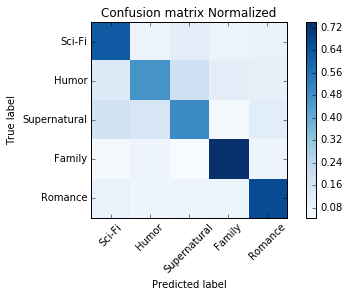

In [19]:
evaluate_prediction(bow_nmf_predictions, test_data['genre'])

In [21]:
tfidf_train = tfidf_vectorizer.fit_transform(bow_train)
tfidf_test = tfidf_vectorizer.transform(bow_test)

In [22]:
tfidf_nmf_params = {'NMF__n_components':[5, 25, 100, 150],
                    'NMF__tol': [0.0001, 0.001, 0.005], 
                    'NMF__max_iter': [100, 300, 500]
                    }

In [23]:
tfidf_nmf = Pipeline([('NMF', NMF(init='nndsvd', solver='cd', random_state=42)),
                      ('classifier', classifier)
                      ])

In [24]:
tfidf_nmf_grid_search = RandomizedSearchCV(estimator=tfidf_nmf,
                                           param_distributions=tfidf_nmf_params,
                                           n_iter=10,
                                           scoring='f1_weighted',
                                           n_jobs=-1,
                                           verbose=1,
                                           random_state=42
                                           )

In [25]:
tfidf_nmf_grid_search.fit(tfidf_train, train_data['genre'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 144.8min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('NMF', NMF(alpha=0.0, beta=1, eta=0.1, init='nndsvd', l1_ratio=0.0, max_iter=200,
  n_components=None, nls_max_iter=2000, random_state=42, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)), ('classifier', RandomForestClassifier(bootstrap=False, class_weight=None, criteri...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'NMF__n_components': [5, 25, 100, 150], 'NMF__tol': [0.0001, 0.001, 0.005], 'NMF__max_iter': [100, 300, 500]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          scoring='f1_weighted', verbose=1)

In [26]:
tfidf_nmf_grid_search.grid_scores_

[mean: 0.54301, std: 0.00257, params: {'NMF__n_components': 25, 'NMF__tol': 0.001, 'NMF__max_iter': 500},
 mean: 0.34101, std: 0.00566, params: {'NMF__n_components': 5, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.58680, std: 0.00233, params: {'NMF__n_components': 100, 'NMF__tol': 0.001, 'NMF__max_iter': 100},
 mean: 0.58624, std: 0.00316, params: {'NMF__n_components': 100, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.58714, std: 0.00292, params: {'NMF__n_components': 100, 'NMF__tol': 0.0001, 'NMF__max_iter': 300},
 mean: 0.58868, std: 0.00512, params: {'NMF__n_components': 150, 'NMF__tol': 0.001, 'NMF__max_iter': 300},
 mean: 0.58868, std: 0.00512, params: {'NMF__n_components': 150, 'NMF__tol': 0.001, 'NMF__max_iter': 100},
 mean: 0.59057, std: 0.00391, params: {'NMF__n_components': 150, 'NMF__tol': 0.005, 'NMF__max_iter': 300},
 mean: 0.59057, std: 0.00391, params: {'NMF__n_components': 150, 'NMF__tol': 0.005, 'NMF__max_iter': 500},
 mean: 0.34101, std: 0.00566, params: {

In [27]:
tfidf_nmf_grid_search.best_params_ 

{'NMF__max_iter': 300, 'NMF__n_components': 150, 'NMF__tol': 0.005}

In [28]:
tfidf_nmf_predictions = tfidf_nmf_grid_search.predict(tfidf_test)

accuracy 0.62490211433
f1_Score : 0.62339088568
confusion matrix
 [[1104  181  216  115  137]
 [ 194  915  330  162  156]
 [ 261  291  904   91  208]
 [ 106  126   72 1427  130]
 [ 163  153  136  125 1236]]
(row=expected, col=predicted)
classification report
              precision    recall  f1-score   support

      Sci-Fi       0.63      0.60      0.62      1828
       Humor       0.52      0.55      0.53      1666
Supernatural       0.52      0.55      0.53      1658
      Family       0.77      0.74      0.75      1920
     Romance       0.68      0.66      0.67      1867

 avg / total       0.63      0.62      0.63      8939



C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


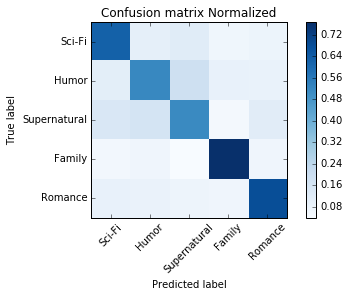

In [29]:
evaluate_prediction(tfidf_nmf_predictions, test_data['genre'])

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import LinearSVC
bow_lda_pipeline = Pipeline([('lda',LatentDirichletAllocation(batch_size=1000, evaluate_every=10, n_jobs=-1, random_state=42)),
                             ('clf', LinearSVC(random_state=42, verbose=1))
                             ])
bow_lda_params = {'clf__C': [0.1, 1.0, 10],
                  'clf__class_weight': [None, 'Balanced'],
                  'clf__penalty': ['l1', 'l2'],
                  'clf__max_iter': [1000, 2500, 5000],
                  'lda__n_topics': [10, 100, 1000],
                  'lda__learning_decay': [0.5, 0.75, 0.9],
                  'lda__max_iter': [10, 100, 250]
                  }

In [36]:
bow_lda_search = RandomizedSearchCV(estimator=bow_lda_pipeline,
                                    param_distributions=bow_lda_params,
                                    n_iter=18,
                                    scoring='f1_weighted',
                                    n_jobs=-1,
                                    verbose=1,
                                    random_state=42
                                    )

In [ ]:
bow_lda_search.fit(bow_train, train_data['genre'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
bow_lda_search.grid_scores_

In [ ]:
bow_lda_search.best_params_ 

In [ ]:
bow_lda_predictions = bow_lda_search.predict(bow_test)

In [ ]:
evaluate_prediction(bow_lda_predictions, test_data['genre'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import LinearSVC
bow_lda_pipeline = Pipeline([('lda',LatentDirichletAllocation(batch_size=1000, evaluate_every=10, n_jobs=-1, random_state=42)),
                             ('clf', LinearSVC(random_state=42, verbose=1))
                             ])
bow_lda_params = {'clf__C': [0.1, 1.0, 10],
                  'clf__class_weight': [None, 'Balanced'],
                  'clf__penalty': ['l1', 'l2'],
                  'clf__max_iter': [1000, 2500, 5000],
                  'lda__n_topics': [10, 100, 1000],
                  'lda__learning_decay': [0.5, 0.75, 0.9],
                  'lda__max_iter': [10, 100, 250]
                  }